In [4]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import warnings
import yfinance as yf
from datetime import date, timedelta
from operator import itemgetter
from statsmodels.tsa.stattools import adfuller

from algo.cointegration.augmented_dickey_fuller import adf_stationarity
from algo.forecasting.arima_multiprocessing import arima_parallel


sns.set_style("darkgrid")

In [5]:
num_data = 10000
end_date = date.today()
start_date = end_date - timedelta(hours=num_data)
interval = "1d"

vix_df = yf.download("^VIX", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)
vix_df.rename(columns={"Adj Close": "vix"}, inplace=True)
vix_df = vix_df[["vix"]]
vix_df.tail()

[*********************100%***********************]  1 of 1 completed


,vix
Date,
2023-01-23,19.809999
2023-01-24,19.200001
2023-01-25,19.080000
2023-01-26,18.730000
2023-01-27,18.510000


In [6]:
ticker = "SPY"  # S&P 500 ETF
# ticker = "MES=F"  # Micro E-mini S&P 500 Futures

ticker_df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval) 
ticker_df.rename(columns={"Adj Close": "price", "Volume": "volume"}, inplace=True)
ticker_df = ticker_df[["price", "volume"]]
ticker_df.tail()

[*********************100%***********************]  1 of 1 completed


,price,volume
Date,,
2023-01-23,400.630005,84178800
2023-01-24,400.200012,59524900
2023-01-25,400.350006,84800300
2023-01-26,404.750000,72287400
2023-01-27,405.679993,68280700


In [7]:
# TODO: properly. Temporary hack, but better to allign both frames to a common timezone, especially if hourly.
ticker_df = ticker_df.tz_localize(None)
ticker_df.tail()

,price,volume
Date,,
2023-01-23,400.630005,84178800
2023-01-24,400.200012,59524900
2023-01-25,400.350006,84800300
2023-01-26,404.750000,72287400
2023-01-27,405.679993,68280700


In [8]:
df = ticker_df.join(vix_df)
df.dropna(inplace=True)
df.tail()

,price,volume,vix
Date,,,
2023-01-23,400.630005,84178800,19.809999
2023-01-24,400.200012,59524900,19.200001
2023-01-25,400.350006,84800300,19.080000
2023-01-26,404.750000,72287400,18.730000
2023-01-27,405.679993,68280700,18.510000


# Transform Data - make stationary

In [9]:
# Test for Stationarity - ADF Test.
is_stationary = adf_stationarity(df["price"], trend="c")
print(f"price stationary = {is_stationary}")

# Perform differencing until stationary.
periods = 1
df[f"price_diff_{periods}"] = df["price"].diff(periods=periods)
df.dropna(inplace=True)

is_stationary = adf_stationarity(df["price_diff_1"], trend="c")
print(f"price diff 1 stationary = {is_stationary}")

price stationary = False
price diff 1 stationary = True


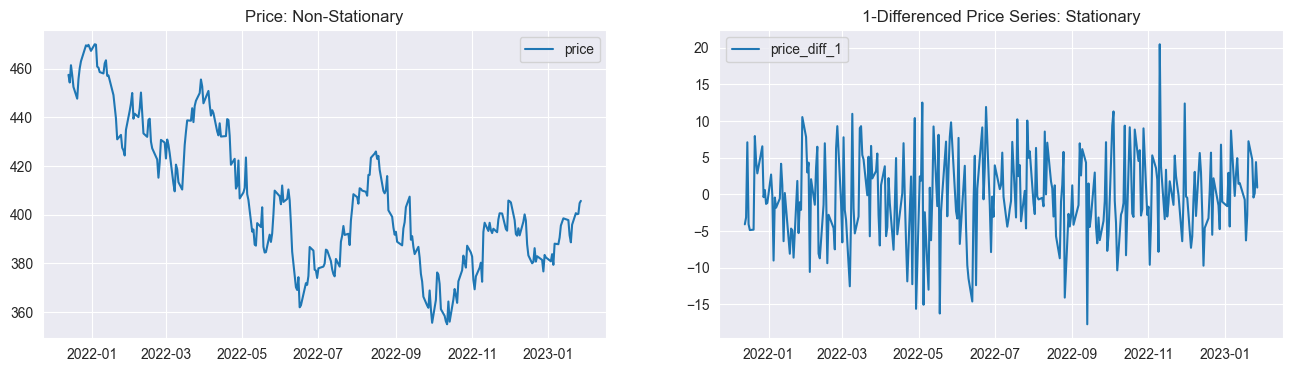

In [10]:
fig = plt.figure()
fig.set_size_inches(16, 4)

# Price.
plt.subplot(1, 2, 1)
plt.title("Price: Non-Stationary")
plt.plot(df["price"], label="price")
plt.legend()

# Differenced Price.
plt.subplot(1, 2, 2)
plt.title("1-Differenced Price Series: Stationary")
plt.plot(df["price_diff_1"], label="price_diff_1")
plt.legend()

plt.show()

# Fit AR(I)MA Model

In [11]:
# Number of lags to trial.
lags = 25

conf_interval = {95: 0.05}
alpha = conf_interval[95]

acf, conf = sm.tsa.stattools.acf(x=df["price"], nlags=lags, alpha=alpha)

# Centre the confidence boundaries on the data.
conf_centred = conf - np.expand_dims(acf, axis=-1)

# Significant data: outside of the blue bands (above or below).
sig_data = np.abs(acf) >= conf_centred[:, 1]

# Largest lag of raw (non-differenced) price data.
max_lag = max(index for index, value in enumerate(sig_data) if value)
max_lag

18

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


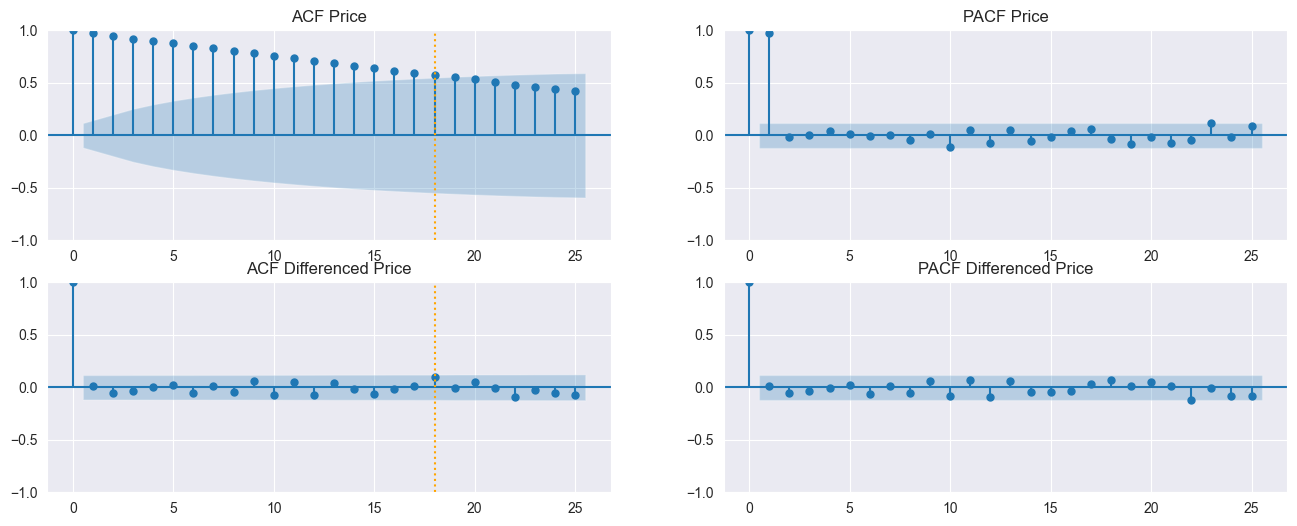

In [12]:
# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price"]

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Price")

ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF Price")

# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price_diff_1"]

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax3)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Differenced Price")

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax4)
plt.title("PACF Differenced Price")

plt.show()

In [13]:
# Already differenced to I(0): d=0.
d_candidates = (0,)

p_candidates = range(max_lag)
q_candidates = range(max_lag)

num_processes = 16

data = df["price_diff_1"].values
# data = df[["price_diff_1", "vix"]].values

hyper_opt = arima_parallel(p_candidates=p_candidates, d_candidates=d_candidates, q_candidates=q_candidates, data=data, num_processes=num_processes)

# Find the (p, q) corresponding to the minimum AIC.
p_opt, q_opt = min(hyper_opt, key=hyper_opt.get)
print(f"p_opt = {p_opt}, q_opt = {q_opt}")

# Best `num_min` performances for (p, q) vs. AIC.
num_min = 5
best_candidates = dict(sorted(hyper_opt.items(), key=itemgetter(1))[:num_min])

print(f"Top {num_min}: {best_candidates}")

p_opt = 0, q_opt = 0
Top 5: {(0, 0): 1814.405995266312, (1, 1): 1814.96577381107, (0, 1): 1816.341152696174, (2, 3): 1816.3473402467098, (1, 0): 1816.3484910845305}


# VARMAX

In [14]:
model = sm.tsa.VARMAX(df[["price_diff_1", "vix"]], order=(1,1), trend="n")
res = model.fit()
res.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64869D+00    |proj g|=  2.62357D-02


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.64822D+00    |proj g|=  2.79496D-02

At iterate   10    f=  4.64807D+00    |proj g|=  1.05205D-02

At iterate   15    f=  4.64779D+00    |proj g|=  6.63425D-02

At iterate   20    f=  4.64677D+00    |proj g|=  9.45078D-02

At iterate   25    f=  4.64617D+00    |proj g|=  1.53506D-01

At iterate   30    f=  4.64566D+00    |proj g|=  1.64609D-01

At iterate   35    f=  4.64361D+00    |proj g|=  8.17907D-01

At iterate   40    f=  4.63525D+00    |proj g|=  3.13199D-01

At iterate   45    f=  4.63170D+00    |proj g|=  1.14833D-01

At iterate   50    f=  4.62987D+00    |proj g|=  8.11276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['price_diff_1', 'vix']",No. Observations:,283
Model:,"VARMA(1,1)",Log Likelihood,-1310.253
Date:,"Mon, 30 Jan 2023",AIC,2642.507
Time:,18:58:19,BIC,2682.607
Sample:,0,HQIC,2658.585
,- 283,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.02, 0.02",Jarque-Bera (JB):,"0.15, 14.53"
Prob(Q):,"0.89, 0.90",Prob(JB):,"0.93, 0.00"
Heteroskedasticity (H):,"1.00, 0.86",Skew:,"-0.05, 0.39"
Prob(H) (two-sided):,"0.99, 0.45",Kurtosis:,"3.04, 3.78"
